In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.utils import shuffle

import sys 
sys.path.append('../src/utils/')
sys.path.append('../src/models/')
sys.path.append('../src/visualization/')

from particles import Photon
from seed_finder import SeedFinder

%load_ext autoreload
%autoreload 2

# Load and prepare data for training from one- and two-particle samples

In [2]:
photon_1 = Photon(n_pcl=1)
photon_2 = Photon(n_pcl=2)

photons = [photon_1, photon_2]

In [3]:
Xtrain, ytrain = [], []
Xvalid, yvalid = [], []

for photon in photons:
    Xi, yi = photon.data_for_seed_finder("valid")
    Xtrain.extend(Xi)
    ytrain.extend(yi)

    Xi, yi = photon.data_for_seed_finder("test")
    Xvalid.extend(Xi)
    yvalid.extend(yi)
Xtrain, ytrain = np.array(Xtrain), np.array(ytrain)
Xvalid, yvalid = np.array(Xvalid), np.array(yvalid)

100%|██████████| 50000/50000 [00:12<00:00, 3924.02it/s]


In [4]:
# shuffle the samples randomly
Xtrain, ytrain = shuffle(Xtrain, ytrain, random_state=42)
Xvalid, yvalid = shuffle(Xvalid, yvalid, random_state=42)

# Prepare the model and training

In [5]:
model = SeedFinder().architecture()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy())
model.summary()

2024-01-12 14:26:11.293538: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-12 14:26:11.294163: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-12 14:26:11.294453: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-12 14:26:11.294708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-12 14:26:11.295156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 128)         1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 2400)              5532000   
                                                                 
 dense_1 (Dense)             (None, 500)               1200500   
                                                                 
 dense_2 (Dense)             (None, 1)                 501   

In [6]:
filepath = 'models/seed_finder/run_3/'

checkpoint = ModelCheckpoint(
        str(filepath)+"/weights.{epoch:02d}-{val_loss:.4f}.hdf5", 
        monitor='val_loss', verbose = 1, save_best_only = True, 
        mode='auto', save_freq='epoch')

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30)

# Model training

In [7]:
history = model.fit(Xtrain, ytrain,
                    validation_data=(Xvalid, yvalid), 
                    epochs=30, batch_size=64, 
                    callbacks=[checkpoint, callback])

Epoch 1/30


2024-01-12 14:26:14.894759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-01-12 14:26:14.958248: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


52483/52483 [==============================] - ETA: 0s - loss: 0.0250
Epoch 1: val_loss improved from inf to 0.01933, saving model to models/seed_finder/run_3/weights.01-0.0193.hdf5


/Users/polinasimkina/miniconda3/envs/envdeep/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52483/52483 [==============================] - 1000s 19ms/step - loss: 0.0250 - val_loss: 0.0193
Epoch 2/30
52483/52483 [==============================] - ETA: 0s - loss: 0.0182
Epoch 2: val_loss improved from 0.01933 to 0.01824, saving model to models/seed_finder/run_3/weights.02-0.0182.hdf5
52483/52483 [==============================] - 995s 19ms/step - loss: 0.0182 - val_loss: 0.0182
Epoch 3/30
52483/52483 [==============================] - ETA: 0s - loss: 0.0161
Epoch 3: val_loss improved from 0.01824 to 0.01543, saving model to models/seed_finder/run_3/weights.03-0.0154.hdf5
52483/52483 [==============================] - 942s 18ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 4/30
52483/52483 [==============================] - ETA: 0s - loss: 0.0148
Epoch 4: val_loss improved from 0.01543 to 0.01437, saving model to models/seed_finder/run_3/weights.04-0.0144.hdf5
52483/52483 [==============================] - 943s 18ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 5/30
52483/52483 [

In [8]:
model.save(str(filepath))

INFO:tensorflow:Assets written to: models/seed_finder/run_3/assets


INFO:tensorflow:Assets written to: models/seed_finder/run_3/assets


# Draw loss function 

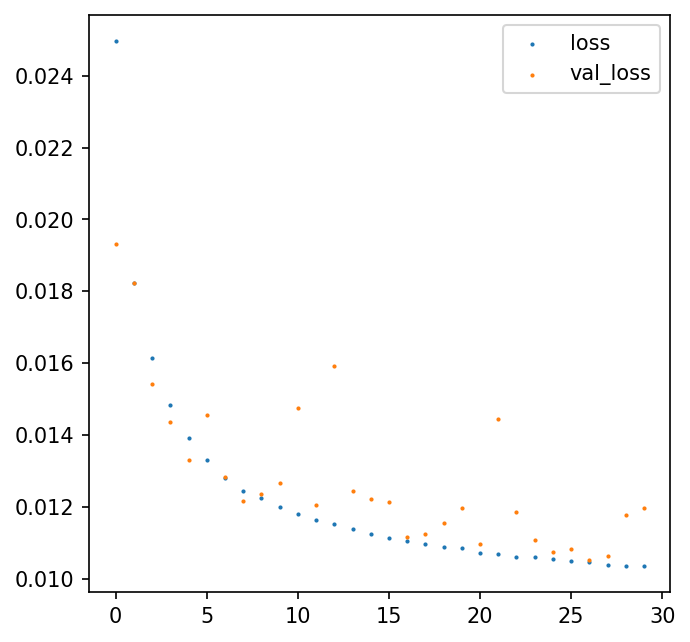

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 150

plt.scatter(np.arange(0,30), history.history["loss"], s=1., label='loss')
plt.scatter(np.arange(0,30), history.history["val_loss"], s=1., label='val_loss')
plt.legend()
plt.savefig(str(filepath) + '/loss_function')
#plt.xlim(0,500)
#plt.ylim(0.,0.01)